In [2]:
import numpy as np
import pywavefront
import torch
import plotly.graph_objects as go

from smplpytorch.pytorch.smpl_layer import SMPL_Layer
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot

## 1. Análisis de conjunto de datos (Amass y UP 3D)

### 1.1 Datos de entrenamiento

In [3]:
train_dataset = np.load('data/amass_up3d_3dpw_train.npz')

In [4]:
train_dataset['fnames'].shape

(347962,)

In [5]:
train_dataset['shapes'].shape

(347962, 10)

In [6]:
train_dataset['poses'].shape

(347962, 72)

### 1.2 Datos de evaluación

In [7]:
val_dataset = np.load('data/up3d_3dpw_val.npz')

In [8]:
val_dataset['fnames'].shape

(11836,)

In [9]:
val_dataset['shapes'].shape

(11836, 10)

In [10]:
val_dataset['poses'].shape

(11836, 72)

## 2. Estrategia de implementacion

### 2.1 Obtención de silueta

#### 2.1.1 Obtención de vertices y facetas con SMPL

In [359]:
smpl_layer = SMPL_Layer(
        center_idx=0,
        gender='neutral',
        model_root='smplpytorch/native/models')

In [360]:
example = {
    'pose': train_dataset['poses'][150].astype(np.float32),
    'shape': train_dataset['shapes'][150].astype(np.float32)
}

In [361]:
example

{'pose': array([-3.19402142e+01,  3.21592021e+00, -1.33620110e+01, -3.38465333e-01,
        -6.03806367e-03,  1.42538950e-01, -1.10902198e-01, -8.10165182e-02,
        -9.00845304e-02,  2.33437389e-01,  6.48195148e-02, -1.26914568e-02,
         4.72283721e-01, -2.79499255e-02, -1.20196335e-01,  6.20747983e-01,
         4.50081341e-02,  8.80234092e-02,  3.28471549e-02,  3.55295166e-02,
        -2.20976528e-02,  7.99649116e-03,  1.35612920e-01, -1.48053348e-01,
        -1.54306099e-01, -2.16698647e-01,  1.65008664e-01,  5.68511859e-02,
         9.15178750e-03, -2.44893264e-02, -2.62344241e-01,  1.72689855e-01,
         3.26869220e-01, -1.32589981e-01,  9.26658362e-02, -2.99614310e-01,
        -1.00368328e-01,  1.24926105e-01,  7.61661232e-02,  1.26729742e-01,
         2.24629417e-01, -5.31017542e-01,  9.78307053e-03,  2.67878966e-03,
         4.22190756e-01,  1.71777800e-01,  3.18926908e-02, -9.30538401e-02,
         3.30384940e-01,  1.40457600e-01, -9.61847067e-01,  2.45347112e-01,
    

In [362]:
pos_p = example['pose'].reshape(1, example['pose'].shape[0])

In [363]:
pos_p2 = pos_p*0
pos_p2[0][50] = 5.6
pos_p2[0][53] = -5.6

In [364]:
pose_params = torch.from_numpy(pos_p2)
shape_params = torch.from_numpy(example['shape'].reshape(1, example['shape'].shape[0]))

In [365]:
print(pose_params.shape)
print(shape_params.shape)

torch.Size([1, 72])
torch.Size([1, 10])


In [366]:
verts, Jtr = smpl_layer(pose_params, th_betas=shape_params)
faces = smpl_layer.th_faces

In [367]:
print(verts.shape)
print(faces.shape)
print(Jtr.shape)

torch.Size([1, 6890, 3])
torch.Size([13776, 3])
torch.Size([1, 24, 3])


##### 2.1.2.1 Pruebas

In [368]:
def buildMesh(vertices, faces):
    x, y, z = vertices[:,:3].T
    I, J, K = faces.T
    mesh = go.Mesh3d(
                x=x,
                y=y,
                z=z,
                i=I,
                j=J,
                k=K,
                name='',
                showscale=False)
    return mesh

In [369]:
def buildLayout():
    layout = go.Layout(width=500,
                   height=500,
                   scene=dict(aspectmode='data',
                              camera=dict(eye=dict(x=2, y=1.5, z=0.2))), 
                  margin=dict(t=50)) 
    return layout

In [370]:
verts_p = verts.reshape(verts.shape[1], verts.shape[2])

In [371]:
mesh = buildMesh(verts_p, faces)
layout = buildLayout()
fig = go.Figure(data=[mesh], layout=layout)
iplot(fig)

In [372]:
thefile = open('test3.obj', 'w')
for item in verts_p:
    thefile.write("v {0} {1} {2}\n".format(item[0],item[1],item[2]))

for item in faces + 1:
    thefile.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0],item[1],item[2]))  

thefile.close()

#### 2.1.2 Visualización de la malla

In [17]:
def buildMesh(vertices, faces):
    x, y, z = vertices[:,:3].T
    I, J, K = faces.T
    mesh = go.Mesh3d(
                x=-x,
                y=-y,
                z=z,
                i=I,
                j=J,
                k=K,
                name='',
                color='white',
                showscale=False)
    return mesh

In [18]:
def updateBuildMesh(mesh):
    mesh.update(lighting=dict(ambient= 1));

In [19]:
def buildLayout():
    layout = go.Layout(width=500,
                   height=500,
                    plot_bgcolor="#000",
                       paper_bgcolor='#000',
                   scene=dict(xaxis=dict(visible=False),
                              yaxis=dict(visible=False),  
                              zaxis=dict(visible=False),
                              aspectmode='data',
                              camera=dict(
                              up=dict(x=0, y=0, z=0),
                                center=dict(x=0, y=0, z=0),
                                eye=dict(x=0, y=0, z=2.5)
                              )), 
                  margin=dict(t=50)) 
    return layout

In [20]:
verts = verts.reshape(verts.shape[1], verts.shape[2])

In [21]:
mesh = buildMesh(verts, faces)
updateBuildMesh(mesh)
layout = buildLayout()
fig = go.Figure(data=[mesh], layout=layout)
#iplot(fig)

In [22]:
fig

## 3. Detectron2

In [56]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib.image import imread
from PIL import Image  

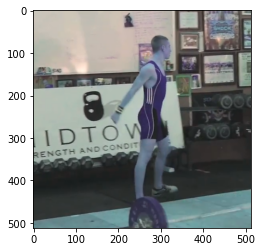

In [58]:
im = cv2.imread("./0000.png")
plt.imshow(im)

In [59]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [61]:
mask_array = outputs['instances'].pred_masks.cpu().numpy()

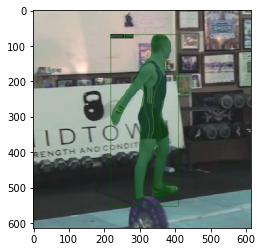

In [62]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [63]:
def cropper(org_image_path, mask_array):
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    img = imread(str(org_image_path))
    output = np.zeros_like(img)
    for i in range(num_instances):
        mask_array_instance.append(mask_array[:, :, i:(i+1)])
        output = np.where(mask_array_instance[i] == True, 255, output)
    return output

In [64]:
silhouette =cropper("./0000.png", mask_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


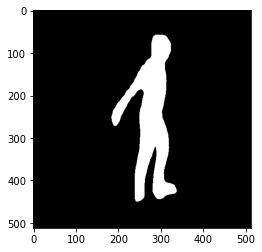

In [65]:
plt.imshow(silhouette)

In [45]:
silhouette.shape

(1280, 960, 3)